# Ecualización del Histograma
## ¿Cómo realizamos la Ecualización del Histograma manualmente?

### Librerías

In [1]:
# Importar Librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from google.colab import files
import pandas as pd
# filtra warnings
import warnings
warnings.filterwarnings('ignore')

### Funciones

In [2]:
# Función para redimensionar la imagen
def resize_image(image, size):
    return cv2.resize(image, (size, size), interpolation=cv2.INTER_AREA)

# Función para mostrar una imagen con los valores de intensidad pintados
def mostrar_imagen_con_valores(imagen, titulo):
    plt.imshow(imagen, cmap="gray")
    plt.title(titulo)
    plt.axis("off")
    for i in range(imagen.shape[0]):
        for j in range(imagen.shape[1]):
            value = imagen[i, j]
            plt.text(j, i, f"{value}", color="red", ha="center", va="center", fontsize=8)

# Función para calcular y mostrar histograma y CDF
def mostrar_histograma_e_cdf(imagen, titulo, ax):
    hist, bins = np.histogram(imagen.flatten(), 256, [0, 256])
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    ax.plot(cdf_normalized, color="b", label="CDF")
    ax.hist(imagen.flatten(), bins=256, color="gray", alpha=0.7, label="Histograma")
    ax.set_title(titulo)
    ax.set_xlabel("Intensidad")
    ax.set_ylabel("Frecuencia")
    ax.legend()

### Cargamos Imagen y Redimensionamos

Saving image_hist.png to image_hist (2).png


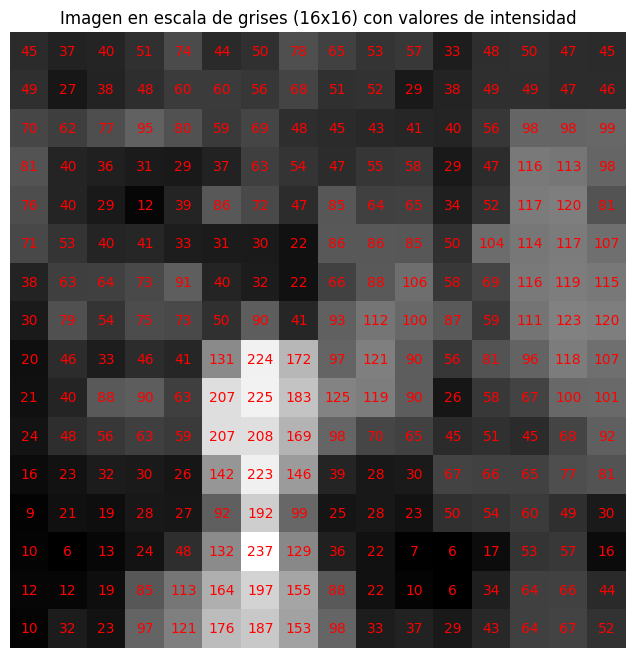

In [14]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Redimensionar la imagen a 16x16 píxeles, puedes probar a cambiar a otras resoluciones! 32x32 etc
size_x = 16
size_y = 16
resized_image = cv2.resize(image, (size_x, size_y), interpolation=cv2.INTER_AREA)

# Crear la figura
plt.figure(figsize=(8, 8))
plt.imshow(resized_image, cmap="gray")
plt.title(f"Imagen en escala de grises ({size_x}x{size_y}) con valores de intensidad")
plt.axis("off")

# Añadir los valores de intensidad en cada píxel
for i in range(resized_image.shape[0]):
    for j in range(resized_image.shape[1]):
        value = resized_image[i, j]
        plt.text(j, i, f"{value}", color="red", ha="center", va="center", fontsize=10)

# Mostrar la imagen con los valores
plt.show()

### Frecuencia de intensidades y suma acumulativa

In [15]:
# Calcular la frecuencia de intensidades
unique, counts = np.unique(resized_image, return_counts=True)
frequency_df = pd.DataFrame({"Intensity": unique, "Frequency": counts})

# Calcular la suma acumulativa
frequency_df["Cumulative Sum"] = frequency_df["Frequency"].cumsum()
frequency_df

,Intensity,Frequency,Cumulative Sum
0,6,3,3
1,7,1,4
2,9,1,5
3,10,3,8
4,12,3,11
...,...,...,...
115,208,1,252
116,223,1,253
117,224,1,254
118,225,1,255


### Representación Gráfica del histograma y la suma acumulativa de intensidades
- CDF (Cumulative Distribution Frequency)

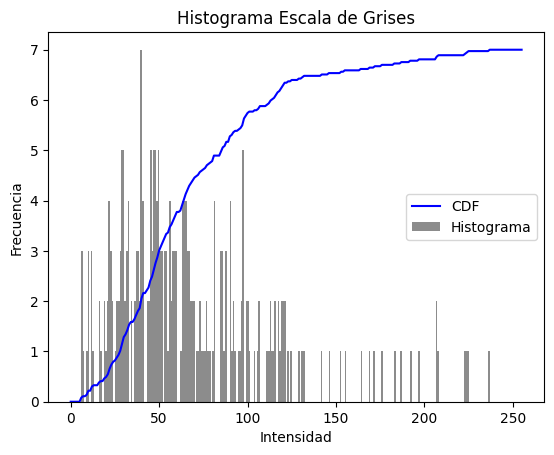

In [16]:
hist,bins = np.histogram(resized_image.flatten(),256,[0,256])

cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()

# Histograma de la imagen original
plt.plot(cdf_normalized, color = 'b')
plt.hist(resized_image.flatten(), bins=256, color='gray', alpha=0.9)
plt.title("Histograma Escala de Grises")
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")
plt.legend(["CDF", "Histograma"])
plt.show();

# Procedemos a calcular la ecualización del histograma

## Introducción

La ecualización del histograma redistribuye los valores de intensidad de una imagen para mejorar su contraste. El cálculo se basa en la fórmula siguiente:

### Fórmula

$$
h(v) = \text{round}\left(\frac{\text{cdf}(v) - \text{cdf}_{\text{min}}}{(M \cdot N) - \text{cdf}_{\text{min}}} \cdot (L - 1)\right)
$$

Donde:

- $h(v)$: Intensidad de salida para un nivel $v$.
- $\text{cdf}(v)$: Función de distribución acumulativa (CDF) para el nivel $v$.
- $\text{cdf}_{\text{min}}$: Valor mínimo de la CDF que no es cero.
- $M \cdot N$: Número total de píxeles en la imagen. Ejemplo con 16x16
- $L$: Número total de niveles de intensidad (256 para imágenes de 8 bits).


---

## Ejemplo

Supongamos que tenemos la siguiente tabla de valores de intensidad y sus correspondientes valores acumulativos (CDF):

| Valor de Intensidad         | CDF                     |
|-----------------------------|-------------------------|
| 89                          | 26                      |
| 90                          | 27                      |
| 95                          | 28                      |
| **96**                      | **29**                  |
| 97                          | 139                     |




 Cálculo para \( v = 96 \)

$$
h(96) = \text{round}\left(\frac{29 - 1}{255} \cdot 255\right)=\text{round}(0.1098 \cdot 255)= 28
$$


Aplicando esta fórmula para cada píxel de la imagen, obtenemos la matriz transformada:





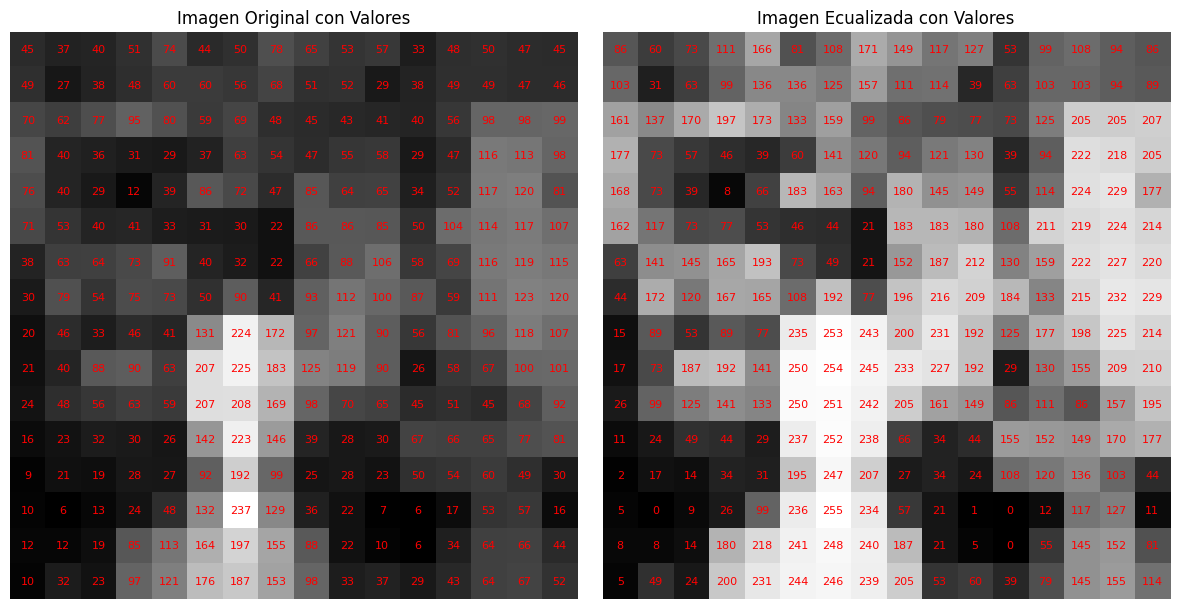

In [17]:
# Calcular el histograma y el CDF
unique, counts = np.unique(resized_image, return_counts=True)
cdf = np.cumsum(counts)
cdf_min = np.min(cdf)
total_pixels = resized_image.size
L = 256  # Rango de intensidades (0-255)

# Crear un mapa de mapeo para intensidades
mapping = {}
for intensity, freq, cdf_val in zip(unique, counts, cdf):
    mapping[intensity] = round(((cdf_val - cdf_min) / (total_pixels - cdf_min)) * (L - 1))

# Ecualizar la imagen usando el mapeo
equalized_image = np.zeros_like(resized_image)
for intensity in unique:
    equalized_image[resized_image == intensity] = mapping[intensity]

# Crear la figura y mostrar las imágenes lado a lado
plt.figure(figsize=(12, 6))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
mostrar_imagen_con_valores(resized_image, "Imagen Original con Valores")

# Mostrar la imagen ecualizada
plt.subplot(1, 2, 2)
mostrar_imagen_con_valores(equalized_image, "Imagen Ecualizada con Valores")

plt.tight_layout()
plt.show()

## Utilizando OpenCV obtenemos los mismo resultados

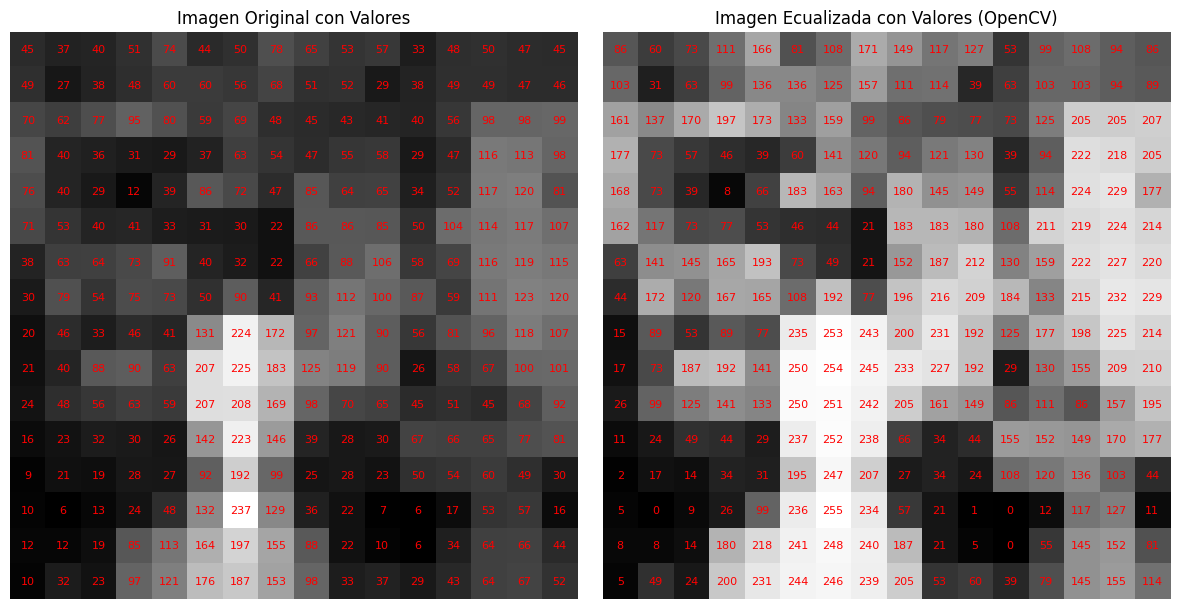

In [18]:
# Ecualizar la imagen utilizando OpenCV
equalized_image_cv2 = cv2.equalizeHist(resized_image)

# Crear la figura y mostrar las imágenes lado a lado
plt.figure(figsize=(12, 6))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
mostrar_imagen_con_valores(resized_image, "Imagen Original con Valores")

# Mostrar la imagen ecualizada
plt.subplot(1, 2, 2)
mostrar_imagen_con_valores(equalized_image_cv2, "Imagen Ecualizada con Valores (OpenCV)")

plt.tight_layout()
plt.show()


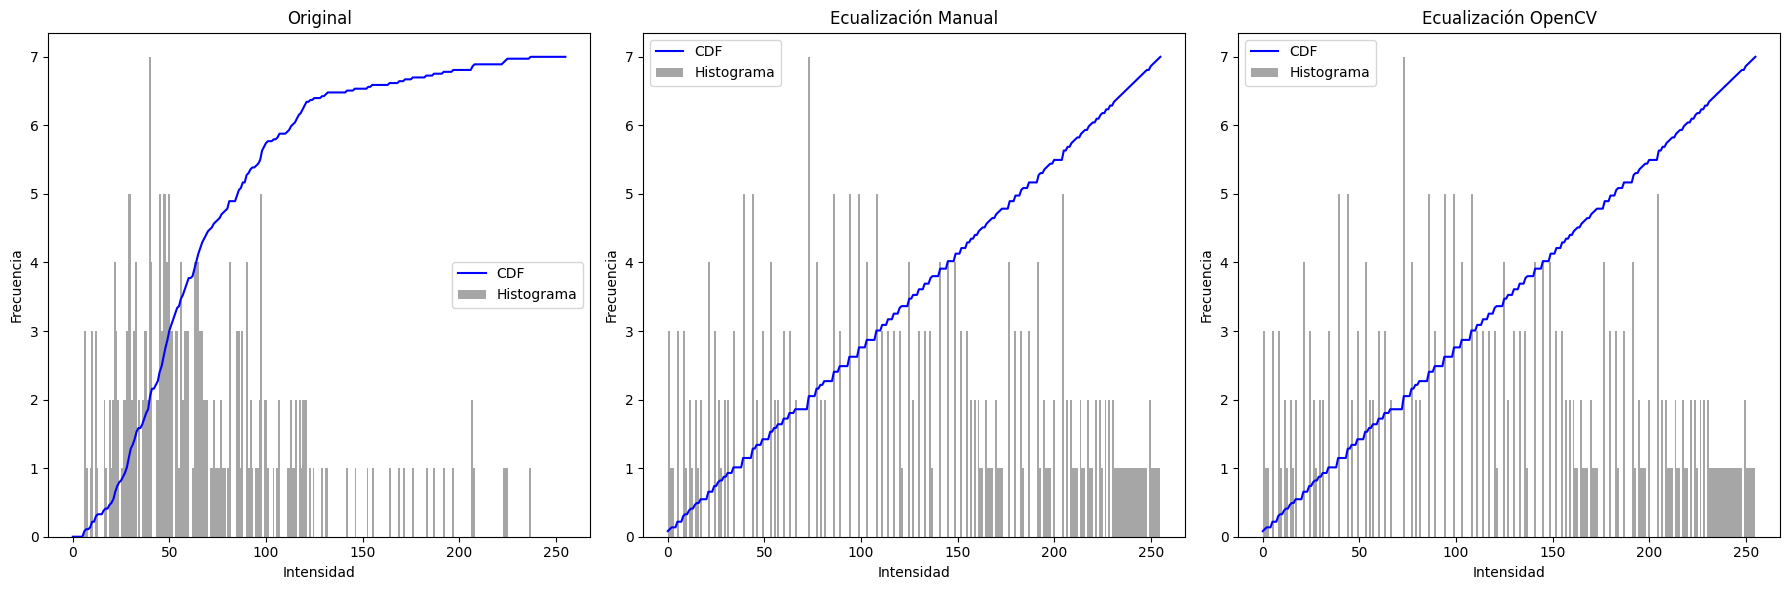

In [19]:
# Crear la figura para los tres casos
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Histograma y CDF para imagen original
mostrar_histograma_e_cdf(resized_image, "Original", axs[0])
# Histograma y CDF para ecualización manual
mostrar_histograma_e_cdf(equalized_image, "Ecualización Manual", axs[1])
# Histograma y CDF para ecualización con OpenCV
mostrar_histograma_e_cdf(equalized_image_cv2, "Ecualización OpenCV", axs[2])

plt.tight_layout()
plt.show()